# Homework 3
## Author: Siddhant Madan

### Import libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

### Get data

In [2]:
path = '/Users/siddhantmadan/Documents/Berkeley MFE/Preprogram/Python/UCB-MFE-python-preprogram/Homeworks/HW3/data/hw3.csv'
data = pd.read_csv(path)
data.set_index('ts', inplace=True)
data.sort_index(inplace=True)

### Perform exploratory data analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2667 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


We see there are quite a few missing values in the `close` column. Let us check with plots for each token.

In [4]:
def plot_token_values(data, column):
    """
    Plot values in `column` for each token through time
    
    Parameters
    ----------
    df : pandas dataframe
        The dataframe with the token and the corresponding
        values to be plotted, indexed by time
        
    colums : str
        Name of `column` that needs to be plotted
    
    """
    tokens_in_data = data.token.unique()

    plot_cols = 2 # how many columns we want in the subplots
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_data.size / plot_cols), ncols=plot_cols, figsize=(16, 5 * math.ceil(tokens_in_data.size / plot_cols)))

    idx = 0
    for token, token_data in data[['token', column]].groupby('token'):
        ax = token_data[column].plot(ax=axes[idx // plot_cols, idx % plot_cols], label=token, rot=45)
        _ = axes[idx // plot_cols, idx % plot_cols].legend()

        idx += 1

    fig.tight_layout()
    fig.suptitle(f'{column.capitalize()} Values of All Tokens Through Time')
    fig.subplots_adjust(top=0.96)

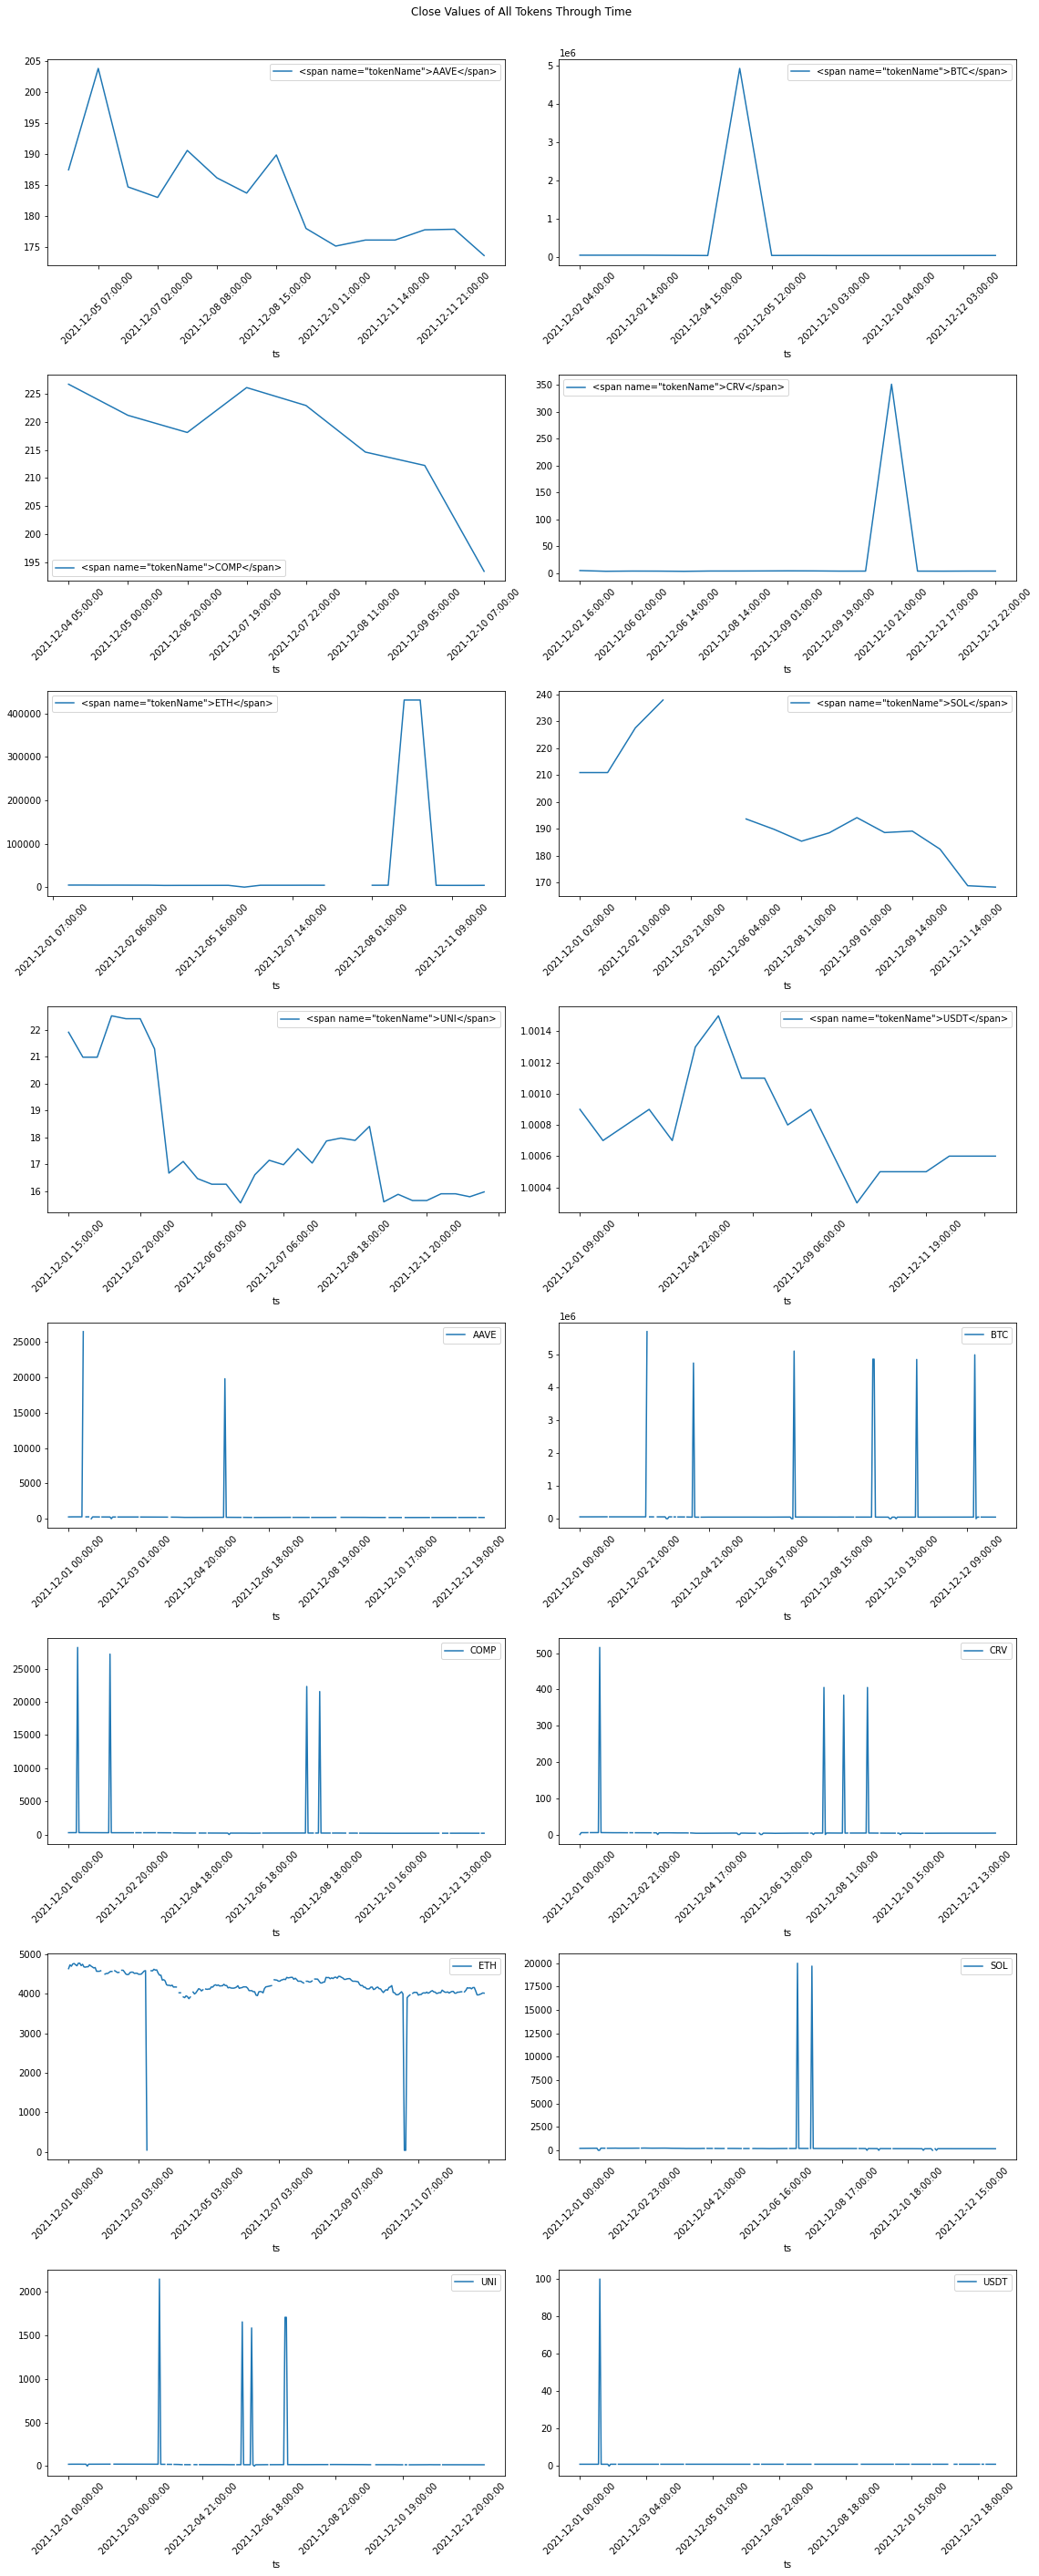

In [5]:
plot_token_values(data, 'close')

We gather from the plots that our dataset has the following issues:
 - Incorrectly formatted token names
 - Missing `close` data for some tokens
 - Outliers in the values of `close` prices

### Correct incorrectly formatted names of tokens

First, let us correct the names of the tokens in the `token` column:

We see that every token has a garbled version of its name with HTML tags on both sides of its name. We need to remove these tags.

In [6]:
# Get rows with distorted names
bad_name_bool = data['token'].str.contains('<span name="tokenName">')

# Remove the HTML tags from the names of the tokens
data.loc[bad_name_bool, 'token'] = data.loc[bad_name_bool, 'token'].str.replace('<[^<]+?>', '', regex=True)

In [7]:
# Check unique token names and their counts
data['token'].str.replace('<[^<]+?>', '', regex=True).value_counts().to_frame()

,token
UNI,342
BTC,337
CRV,335
SOL,334
USDT,333
COMP,332
AAVE,328
ETH,326


### Remove duplicate rows

So, we have sorted the issue of garbled token names. Let us also look at the number of unique dates in the dataset.

In [8]:
data.index.nunique()

295

This is strange because the number of dates is less than the number of rows corresponding to each token. Let us check if there are any duplicate rows in the dataset.

In [9]:
data.duplicated().sum()

307

Indeed, there are quite a few duplicate rows in the dataset. Let us remove them and let us keep the most recently included data.

In [10]:
data.drop_duplicates(keep='last', inplace=True)

Let us again check the number of rows for each token and the number of unique dates.

In [11]:
data['token'].value_counts().to_frame()

,token
ETH,295
BTC,295
COMP,295
CRV,295
AAVE,295
USDT,295
UNI,295
SOL,295


In [12]:
data.index.nunique()

295

They are now equal, as they should be.

We have now resolved the issues of bad token names and of duplication in the data. Let us plot the close prices of each token again to see what issues still remain.

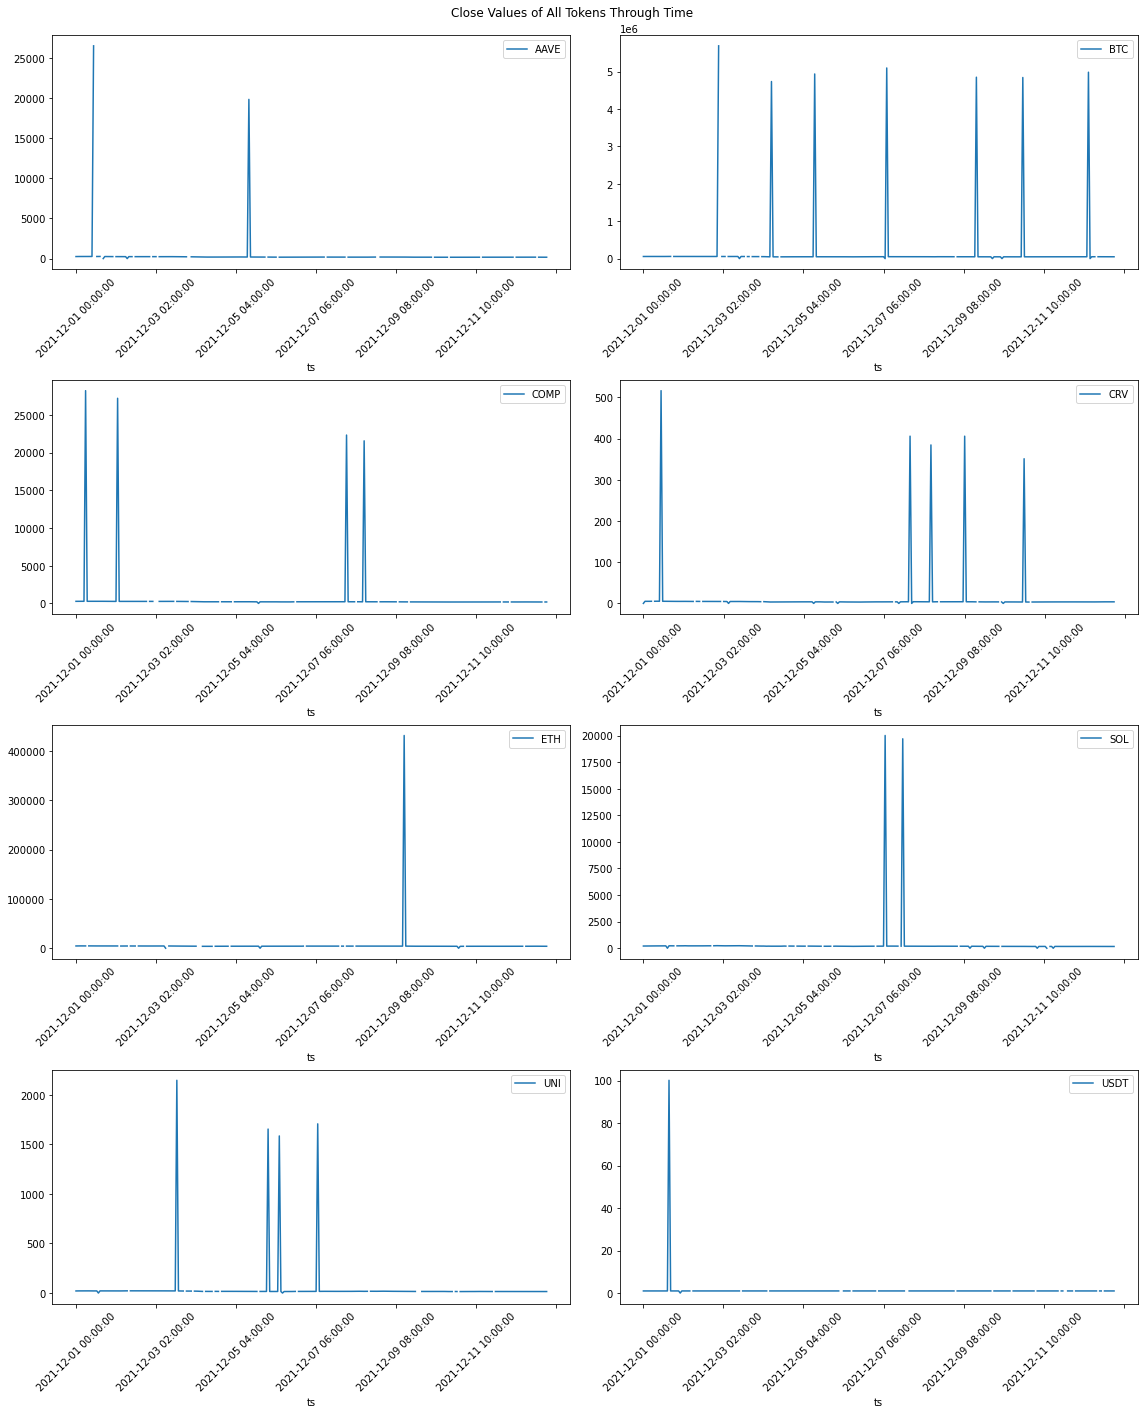

In [13]:
plot_token_values(data, 'close')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2360 non-null   float64
 1   high       1910 non-null   float64
 2   low        2104 non-null   float64
 3   close      2244 non-null   float64
 4   volume     2360 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2360 non-null   object 
 7   chain      2360 non-null   object 
dtypes: float64(6), object(2)
memory usage: 165.9+ KB


We see there are clear outliers and there are some values missing in the series as well. Let us create a heuristic to fill in missing values. We will later use the same heuristic to replace the outliers as well.

### Impute missing values of `close` prices

We will use the following rule to fill the missing values:
 - if both `high` and `low` are available for the period, we will use their average to impute the `close`
 - if only one of `high` or `low` is not available, we will use the average of the one that is available with the `open` to impute the value of the `close`
 - if neither `high` or `low` is available, we will use the `open` to impute the `close` (since there are no missing values for `open`)

In [15]:
print('There are {} rows with missing close prices.'.format(data['close'].isnull().sum()))

There are 116 rows with missing close prices.


In [16]:
def impute_close(df, fill_conditons):
    """
    Impute bad or missing close values in the data
    using high, low, or open
    
    Parameters
    ----------
    df : pandas dataframe
        The dataframe with the data and the close column
        you want to impute
        
    fill_conditions : pandas series
        The boolean series corresponding to the condition
        for missing/bad data you want to impute
        
    Note: The number of rows in df and fill_conditions 
    should be the same
        
    Returns
    -------
    df : pandas dataframe
        The datafram with bad/missing values in the close
        column imputed
    
    """
    
    assert df.shape[0]==fill_conditons.shape[0]
    
    df = df.copy()
    
    # Create boolean conditions for missing data scenarios
    missing_high = df['high'].isnull() # When high is missing
    missing_low = df['low'].isnull() # When low is missing
    high_missing_low_available = ~missing_low & missing_high & fill_conditons # When high is missing but low is available (and close is missing)
    low_missing_high_available = ~missing_high & missing_low & fill_conditons # When low is missing but high is available (and close is missing)
    both_missing = (missing_high & missing_low) & fill_conditons # When both high/low are missing (and close is missing)

    # Use the boolean conditions to fill in missing data for the close when both high and low are available
    df.loc[fill_conditons, 'close'] = (df.loc[fill_conditons, 'high'] + df.loc[fill_conditons, 'low']) / 2

    # Use the boolean conditions to fill in missing data for the close when high is missing but low is available
    df.loc[high_missing_low_available, 'close'] = (df.loc[high_missing_low_available, 'low'] + df.loc[high_missing_low_available, 'open']) / 2

    # Use the boolean conditions to fill in missing data for the close when low is missing but high is available
    df.loc[low_missing_high_available, 'close'] = (df.loc[low_missing_high_available, 'high'] + df.loc[low_missing_high_available, 'open']) / 2

    # Use the boolean conditions to fill in missing data for the close when both high/low are missing
    df.loc[both_missing, 'close'] = df.loc[both_missing, 'open']
    
    return df

In [17]:
# Condition for missing close
missing_close = data['close'].isnull()

# Call function for imputing close
data = impute_close(data, missing_close)

# Check number of missing close values — should be zero
print('There are {} rows with missing close prices remaining.'.format(data['close'].isnull().sum()))

There are 0 rows with missing close prices remaining.


### Remove outliers in `close` values

Now that we have imputed the missing values, let us handle the outliers. We define a `close` value to be an outlier when its value is different from the `open` by a factor of 2 i.e. if the `open` value either increases by more than 100% or it decreases by more than 100%

In [18]:
# Create boolean condition to detect outliers
outlier_condtition = (data['close'] / data['open'] >= 2.0) | (data['close'] / data['open'] < 0.5)

In [19]:
print('There are {} rows with outliers in the close column.'.format(outlier_condtition.sum()))

There are 53 rows with outliers in the close column.


We see that there are 53 instances when the `close` is different from `open` by a factor of more than 2. As per our definition above, these are outliers. We will use the same rules we used to fill in missing values to replace these outliers.

In [20]:
# Call function for imputing close to replace the outliers
data = impute_close(data, outlier_condtition)

In [21]:
outlier_condtition = (data['close'] / data['open'] >= 2.0) | (data['close'] / data['open'] < 0.5)
print('There are {} rows remaining with outliers in the close column.'.format(outlier_condtition.sum()))

There are 0 rows remaining with outliers in the close column.


We see there are no outliers — as per our defintion — in the `close` column now.

Let us plot the `close` prices for all tokens again to see if any issues still remain.

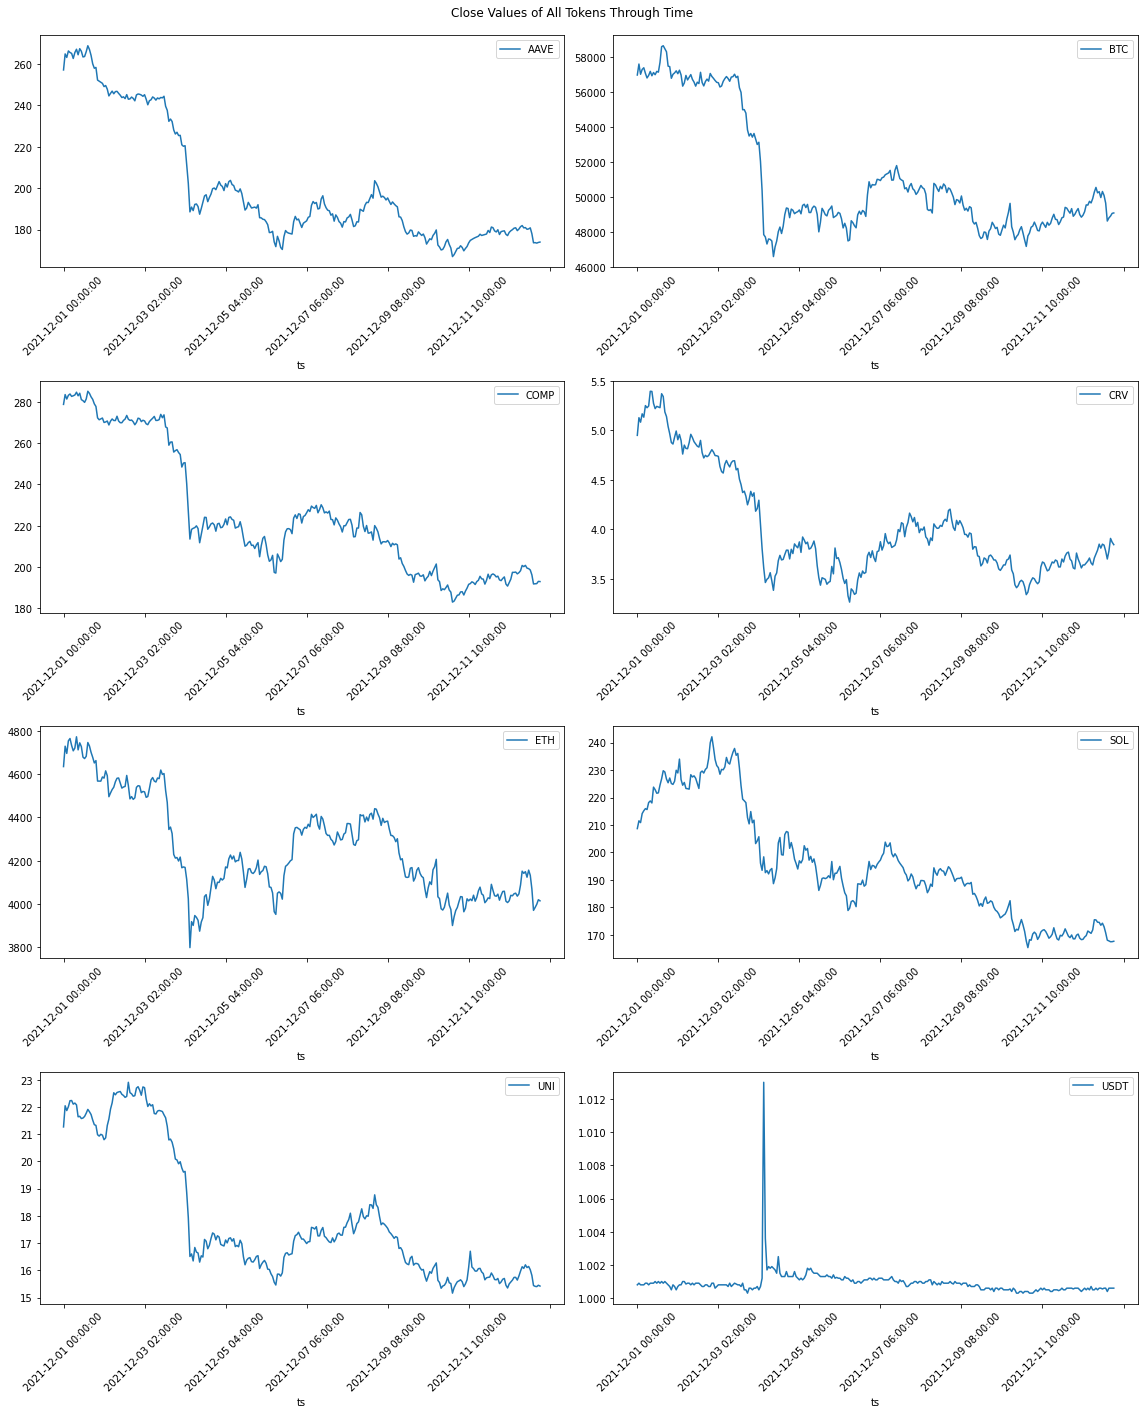

In [22]:
plot_token_values(data, 'close')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 2021-12-01 00:00:00 to 2021-12-13 06:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2360 non-null   float64
 1   high       1910 non-null   float64
 2   low        2104 non-null   float64
 3   close      2360 non-null   float64
 4   volume     2360 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2360 non-null   object 
 7   chain      2360 non-null   object 
dtypes: float64(6), object(2)
memory usage: 165.9+ KB


Now, we see that there are no apparent issues with the `close` values with respect to missing values and outliers (except maybe a sharp spike in `USDT` once).

### Check for issues in the `volume` column

Let us now also plot the `volume` values for all the tokens to check if the issues we encountered with `close` affect `volume` too.

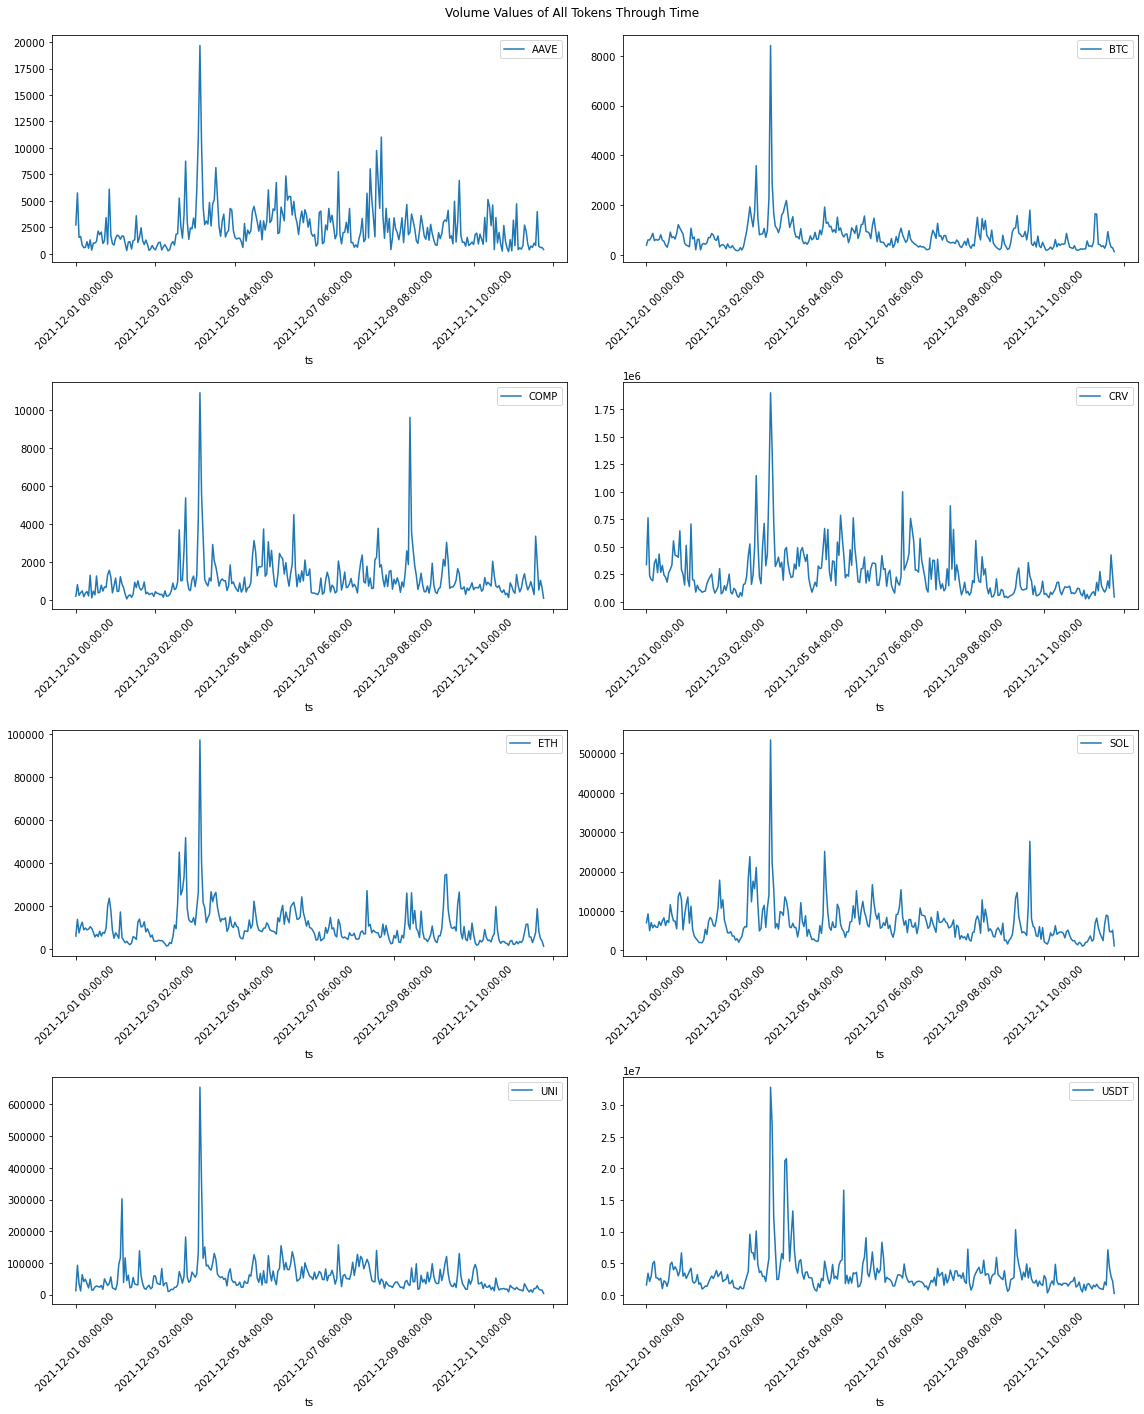

In [24]:
plot_token_values(data, 'volume')

From the plots above, there seem to be no clear issues with the `volume` column values.

Now that we have made sure there are no issues with either the `close` or `volume` values, we can proceed to calculate the dollar volume traded in column `volumeUSD` as follows:

$$volumeUSD = close * volume $$

In [25]:
data['volumeUSD'] = data['close'] * data['volume']

Let us plot the `volumeUSD` for each token:

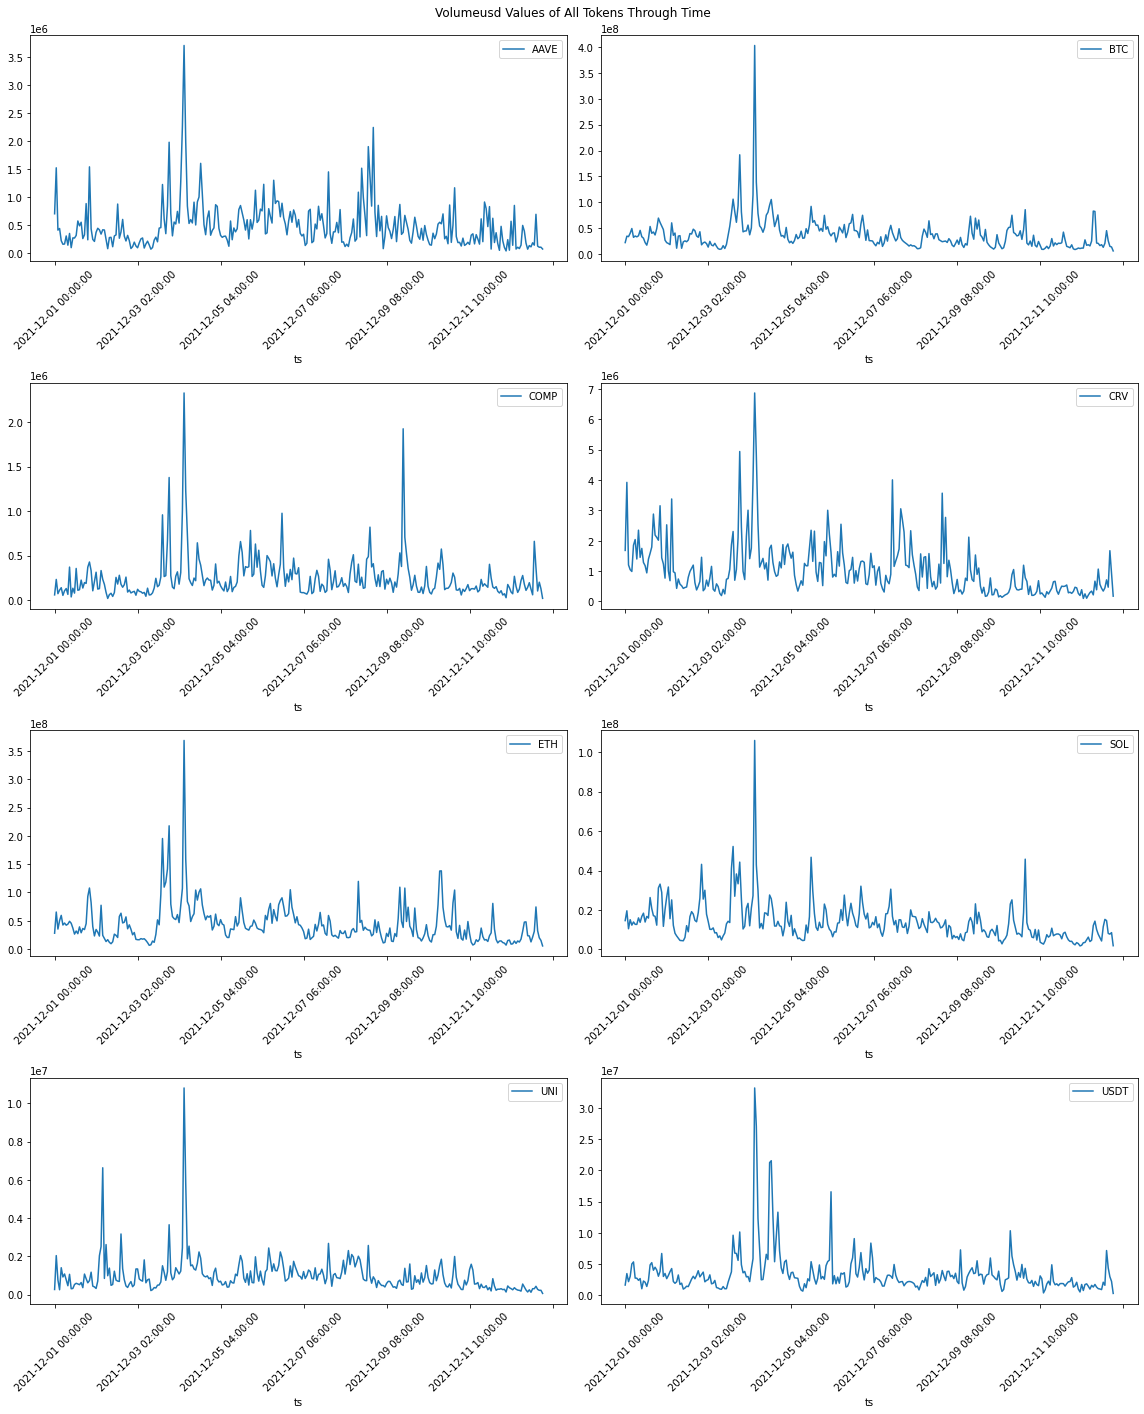

In [26]:
plot_token_values(data, 'volumeUSD')

### Group `volumeUSD` by `chain` for each timestamp

Finally, let us group the total `volumeUSD` values by `chain` for each timestamp.

In [27]:
chain_data = data.groupby(['ts','chain'])['volumeUSD'].sum().to_frame()
chain_data.reset_index(inplace=True)
chain_data

,ts,chain,volumeUSD
0,2021-12-01 00:00:00,BTC,2.213880e+07
1,2021-12-01 00:00:00,ETH,3.057435e+07
2,2021-12-01 00:00:00,SOL,1.461392e+07
3,2021-12-01 00:00:00,USDT,1.589673e+06
4,2021-12-01 01:00:00,BTC,3.455784e+07
...,...,...,...
1175,2021-12-13 05:00:00,USDT,2.180062e+06
1176,2021-12-13 06:00:00,BTC,6.051271e+06
1177,2021-12-13 06:00:00,ETH,5.721253e+06
1178,2021-12-13 06:00:00,SOL,1.876120e+06


In [28]:
def plot_chain_values(data, column):
    """
    Plot values in `column` for each chain through time
    
    Parameters
    ----------
    df : pandas dataframe
        The dataframe with the chain and the corresponding
        values to be plotted, indexed by time
        
    colums : str
        Name of `column` that needs to be plotted
    
    """
    chains_in_data = data.chain.unique()

    plot_cols = 2 # how many columns we want in the subplots
    fig, axes = plt.subplots(nrows=math.ceil(chains_in_data.size / plot_cols), ncols=plot_cols, figsize=(16, 5 * math.ceil(chains_in_data.size / plot_cols)))

    idx = 0
    for chain, chain_data in data[['chain', column]].groupby('chain'):
        ax = chain_data[column].plot(ax=axes[idx // plot_cols, idx % plot_cols], label=chain, rot=45)
        _ = axes[idx // plot_cols, idx % plot_cols].legend()

        idx += 1

    fig.tight_layout()
    fig.suptitle(f'{column.capitalize()} Values of All Chains Through Time')
    fig.subplots_adjust(top=0.94)

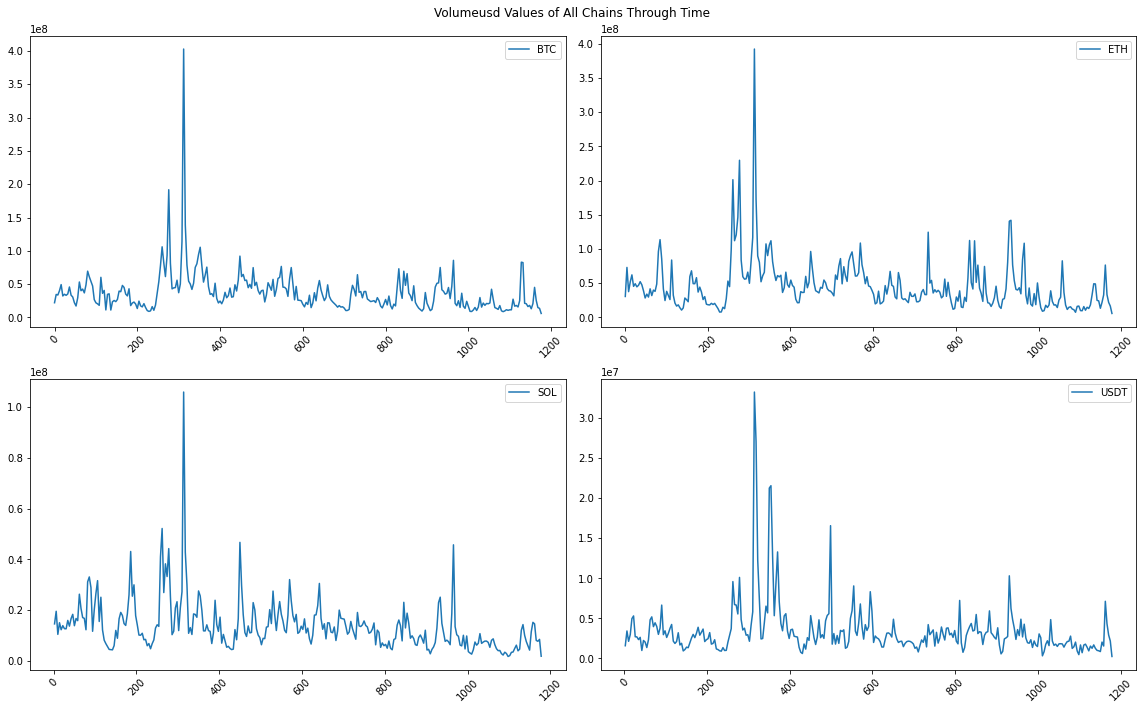

In [29]:
plot_chain_values(chain_data, 'volumeUSD')

### Group `volumeUSD` by `chain` for the whole time period in the dataset 

In [30]:
data.groupby('chain')['volumeUSD'].sum().to_frame()

,volumeUSD
chain,
BTC,1.095893e+10
ETH,1.364762e+10
SOL,4.075514e+09
USDT,1.008247e+09


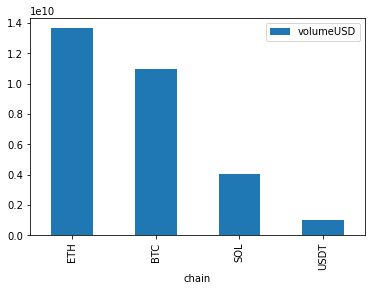

In [31]:
_ = data.groupby('chain')['volumeUSD'].sum().to_frame().sort_values(by='volumeUSD', ascending=False).plot(kind='bar')